# Result Notebook

In [34]:
import os
import json

import numpy as np
import pandas as pd

from IPython.display import display
from pathlib import Path
from omegaconf import OmegaConf

result_path = Path('results')

In [4]:
%%bash
mkdir -p results
fusermount -uz results
sshfs compute.ies:/mnt/work/dhuseljic/results/uncertainty_evaluation results
ls results

ablations
CIFAR10__resnet18
CIFAR10__resnet18_ensemble
CIFAR10__resnet18_mcdropout
CIFAR10__resnet18_sngp
CIFAR10__wideresnet2810
CIFAR10__wideresnet2810_ensemble
CIFAR10__wideresnet2810_mcdropout
CIFAR10__wideresnet2810_sngp


In [35]:
# Define loading functions
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    results = {}

    exp_json = path / 'results_final.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    try:
        cfg =  OmegaConf.load(exp_cfg)
        data = load_json(exp_json)
        result_dict_final_epoch = data['test_history'][-1]

        results['cfg'] = cfg
        results['results'] = result_dict_final_epoch 
    except:
        print(f'{path} has missing results.')
    return results

def get_experiments(result_path, glob_pattern):
    experiments = []
    for exp_path in result_path.glob(glob_pattern):
        d = load_results(exp_path)
        experiments.append(d)
    return experiments

def get_metric_dict(experiments, ignore_metrics=[], return_std=False):
    metric_names = list(experiments[0]['results'].keys())
    d = {}
    for metric_name in metric_names:
        if metric_name in ignore_metrics:
            continue
        value = np.mean([exp['results'][metric_name] for exp in experiments])
        d[metric_name] = value
        if return_std:
            std = np.std([exp['results'][metric_name] for exp in experiments])
            d[metric_name+'_std'] = std
    return d
# experiments = get_experiments(result_path / 'CIFAR10__resnet18', glob_pattern='seed*')
# print(f'Found {len(experiments)} experiments')
# get_metric_dict(experiments)

## Results - Wide-ResNet-28-10

In [17]:
ignore_metrics = [
    'test_SVHN_conf_auroc',
    'test_SVHN_conf_aupr',
    'test_SVHN_dempster_aupr',
    'test_SVHN_dempster_auroc',
    'test_prec',
    'test_loss',
    'test_mce',
    'test_SVHN_entropy_aupr',
    'test_ensemble_cross_entropy',
    'test_gibbs_cross_entropy',
]
exp_names = {
    'deterministic': 'CIFAR10__wideresnet2810',
    "dropout": "CIFAR10__wideresnet2810_mcdropout",
    "ensemble": "CIFAR10__wideresnet2810_ensemble",
    "sngp": "CIFAR10__wideresnet2810_sngp",
}

data = []
for key, name in exp_names.items():
    experiments = get_experiments(result_path / name, glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, ignore_metrics=ignore_metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
display(df)
print(df.to_markdown(floatfmt='0.3f'))

,acc1,nll,tce,auroc
deterministic,96.445998,0.127947,0.015987,0.932431
dropout,96.399998,0.126730,0.014741,0.957641
ensemble,96.885999,0.098419,0.006584,0.975782
sngp,96.291997,0.123090,0.005260,0.959663


|               |   acc1 |   nll |   tce |   auroc |
|:--------------|-------:|------:|------:|--------:|
| deterministic | 96.446 | 0.128 | 0.016 |   0.932 |
| dropout       | 96.400 | 0.127 | 0.015 |   0.958 |
| ensemble      | 96.886 | 0.098 | 0.007 |   0.976 |
| sngp          | 96.292 | 0.123 | 0.005 |   0.960 |


## Results - ResNet18

In [18]:
ignore_metrics = [
    'test_SVHN_conf_auroc',
    'test_SVHN_conf_aupr',
    'test_SVHN_dempster_aupr',
    'test_SVHN_dempster_auroc',
    'test_prec',
    'test_loss',
    'test_SVHN_entropy_aupr',
]
exp_names = {
    'deterministic': 'CIFAR10__resnet18',
    "dropout": "CIFAR10__resnet18_mcdropout",
    "sngp": "CIFAR10__resnet18_sngp",
}

data = []
for key, name in exp_names.items():
    experiments = get_experiments(result_path / name, glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, ignore_metrics=ignore_metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
display(df)
print(df.to_markdown(floatfmt='.3f'))

,acc1,nll,tce,mce,auroc
deterministic,95.299998,0.193056,0.028980,0.024772,0.936323
dropout,94.419998,0.170660,0.006458,0.017068,0.931806
sngp,95.093999,0.161380,0.005736,0.018431,0.961010


|               |   acc1 |   nll |   tce |   mce |   auroc |
|:--------------|-------:|------:|------:|------:|--------:|
| deterministic | 95.300 | 0.193 | 0.029 | 0.025 |   0.936 |
| dropout       | 94.420 | 0.171 | 0.006 | 0.017 |   0.932 |
| sngp          | 95.094 | 0.161 | 0.006 | 0.018 |   0.961 |


## Low Data Regime

In [186]:
import torch
# for each seed, check if the training indices are equal
def check_train_indices(exp1_path, exp2_path, n_seeds=5):
    for seed in range(1, n_seeds+1):
        p1 = exp1_path / f'seed{seed}' 
        p2 = exp2_path / f'seed{seed}'
        # TODO Change
        indices1 = torch.load(p1 / 'train_indices.pth')
        indices2 = torch.load(p2 / 'train_indices.pth')

        if not torch.all(indices1 == indices2):
            print(f'{p1} and {p2} seem to have different training sets.')

In [197]:
ignore_metrics = [
    'test_SVHN_conf_auroc',
    'test_SVHN_conf_aupr',
    'test_SVHN_dempster_aupr',
    'test_SVHN_dempster_auroc',
    'test_prec',
    'test_loss',
    'test_mce',
    'test_SVHN_entropy_aupr',
    'test_ensemble_cross_entropy',
    'test_gibbs_cross_entropy',
]

results = []
all_n_samples = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000]
for n_samples in all_n_samples:
    exp_names = {
        'deterministic': f'ablations/CIFAR10__resnet18__{n_samples}samples',
        'dropout': f'ablations/CIFAR10__resnet18_mcdropout__{n_samples}samples',
        "sngp": f'ablations/CIFAR10__resnet18_sngp__{n_samples}samples', # TODO check __, delete a single _
    }

    # Check train indices
    for key1 in exp_names:
        for key2 in exp_names:
            if key1 == key2: continue
            check_train_indices(result_path / exp_names[key1], result_path / exp_names[key2])

    data = []
    for key, name in exp_names.items():
        experiments = get_experiments(result_path / name, glob_pattern='seed*')
        metric_dict = get_metric_dict(experiments, ignore_metrics=ignore_metrics, return_std=False)
        data.append(metric_dict)

    df = pd.DataFrame(data, index=exp_names.keys())
    df = df.rename(columns={key: f"**{key.split('_')[-1]}**" for key in df.keys()})
    # display(df)
    print(f'`n_samples = {n_samples}`')
    print(df.to_markdown(floatfmt='.2f'))
    print()
    results.append(df.to_dict())

`n_samples = 100`
|               |   **acc1** |   **nll** |   **tce** |   **auroc** |
|:--------------|-----------:|----------:|----------:|------------:|
| deterministic |      21.43 |      6.15 |      0.49 |        0.46 |
| dropout       |      20.67 |      2.30 |      0.10 |        0.48 |
| sngp          |      19.78 |      2.26 |      0.08 |        0.53 |

`n_samples = 200`
|               |   **acc1** |   **nll** |   **tce** |   **auroc** |
|:--------------|-----------:|----------:|----------:|------------:|
| deterministic |      28.74 |      5.43 |      0.53 |        0.46 |
| dropout       |      27.10 |      2.26 |      0.13 |        0.50 |
| sngp          |      23.96 |      2.24 |      0.12 |        0.59 |

`n_samples = 300`
|               |   **acc1** |   **nll** |   **tce** |   **auroc** |
|:--------------|-----------:|----------:|----------:|------------:|
| deterministic |      31.62 |      4.86 |      0.51 |        0.51 |
| dropout       |      30.38 |      2.16 |     

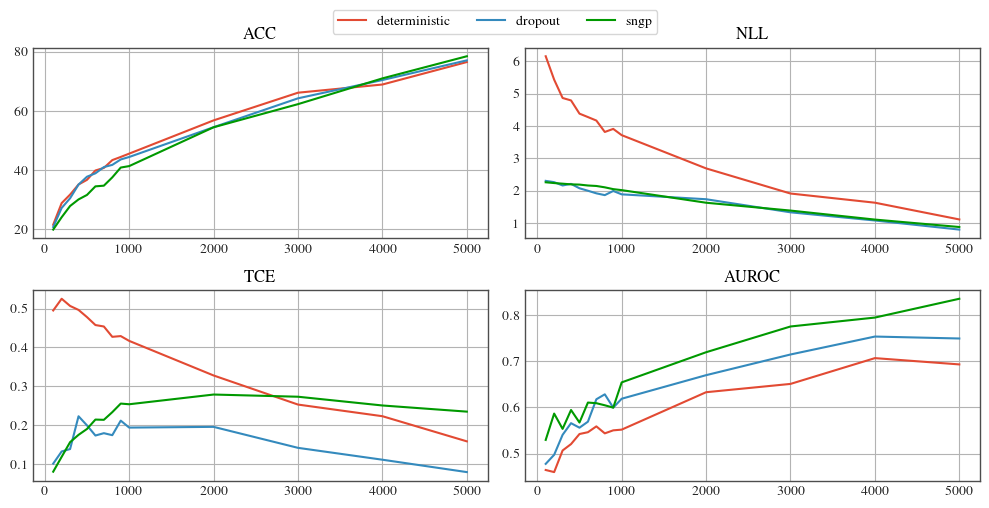

In [188]:
import pylab as plt
fig = plt.figure()
plt.subplot(221)
plt.title('ACC')
tmp = [d['acc1'] for d in results]
plt.plot(all_n_samples, [d['deterministic'] for d in tmp], label='deterministic')
plt.plot(all_n_samples, [d['dropout'] for d in tmp], label='dropout')
plt.plot(all_n_samples, [d['sngp'] for d in tmp], label='sngp')
fig.legend(loc='upper center', ncol=5, bbox_to_anchor=(.5, 1.02))

plt.subplot(222)
plt.title('NLL')
tmp = [d['nll'] for d in results]
plt.plot(all_n_samples, [d['deterministic'] for d in tmp])
plt.plot(all_n_samples, [d['dropout'] for d in tmp], label='dropout')
plt.plot(all_n_samples, [d['sngp'] for d in tmp])

plt.subplot(223)
plt.title('TCE')
tmp = [d['tce'] for d in results]
plt.plot(all_n_samples, [d['deterministic'] for d in tmp])
plt.plot(all_n_samples, [d['dropout'] for d in tmp], label='dropout')
plt.plot(all_n_samples, [d['sngp'] for d in tmp])

plt.subplot(224)
plt.title('AUROC')
tmp = [d['auroc'] for d in results]
plt.plot(all_n_samples, [d['deterministic'] for d in tmp])
plt.plot(all_n_samples, [d['dropout'] for d in tmp], label='dropout')
plt.plot(all_n_samples, [d['sngp'] for d in tmp])
plt.tight_layout()
plt.show()

## SNGP

### Kernel Scale Ablation

In [43]:
exp_names = {
    'scale=0.01': 'ablations/sngp/scale0.01_samples500/CIFAR10/',
    'scale=0.1': 'ablations/sngp/scale0.1_samples500/CIFAR10/',
}

data = []
for key in exp_names:
    experiments = get_experiments(result_path / exp_names[key], glob_pattern='seed*')
    metric_dict = get_metric_dict(experiments, ignore_metrics=ignore_metrics, return_std=False)
    data.append(metric_dict)

df = pd.DataFrame(data, index=exp_names.keys())
df = df.rename(mapper=lambda x: x.split('_')[-1], axis='columns')
display(df)
print(df.to_markdown(floatfmt='0.3f'))

,acc1,nll,tce,mce,auroc
scale=0.01,14.486000,2.300069,0.044744,0.000859,0.414220
scale=0.1,26.560999,2.270327,0.157746,0.002399,0.526883


|            |   acc1 |   nll |   tce |   mce |   auroc |
|:-----------|-------:|------:|------:|------:|--------:|
| scale=0.01 | 14.486 | 2.300 | 0.045 | 0.001 |   0.414 |
| scale=0.1  | 26.561 | 2.270 | 0.158 | 0.002 |   0.527 |
